# Analysis of variance through time

## Sea Level Pressure

In [8]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import glob
import numpy as np
import iris.coord_categorisation
import scipy
from scipy import signal
from scipy import stats
import iris.plot as iplt

def which_models(directory):
    files = glob.glob(directory+'*.nc')
    models = []
    for file in files:
        models.append(file.split('/')[-1].split('_')[0])
    models = np.unique(models)
    return models


######### parameters ##########

variable = 'psl'
# variable = 'zos'
directory = '/data/BatCaveNAS/ph290/hist_'+variable+'/regridded/'
window_size=20
p_value_threshold=0.05
no_models_sig = 10 # the number of models which have to have signioficant trend at the above level to show
plot_min = -1.0
plot_max = 1.0
# plot_min = -0.0001
# plot_max = 0.0001
###############################


models = which_models(directory)




#### models being used

In [2]:
print models

['ACCESS1-0' 'BNU-ESM' 'CCSM4' 'CESM1-CAM5' 'CESM1-FASTCHEM' 'CESM1-WACCM'
 'CMCC-CESM' 'CMCC-CM' 'CMCC-CMS' 'CNRM-CM5' 'CanCM4' 'FIO-ESM'
 'GFDL-CM2p1' 'GFDL-CM3' 'GFDL-ESM2G' 'GFDL-ESM2M' 'GISS-E2-H'
 'GISS-E2-H-CC' 'GISS-E2-R' 'GISS-E2-R-CC' 'HadGEM2-CC' 'HadGEM2-ES'
 'IPSL-CM5A-LR' 'IPSL-CM5A-MR' 'IPSL-CM5B-LR' 'MIROC-ESM-CHEM' 'MIROC4h'
 'MIROC5' 'MPI-ESM-LR' 'MPI-ESM-MR' 'MPI-ESM-P' 'MRI-CGCM3' 'MRI-ESM1'
 'NorESM1-M' 'NorESM1-ME' 'bcc-csm1-1-m' 'inmcm4']


#### variance analysis
for each model
select Jan,feb,mar
mean values within each year
remove linear trend
calculate the standard deviation for each point and year within the window specified above (window centered on the year of interest)
loop through each lat and lon, calculateing the slope and the p-value on the correlation between the stdev timeseries at that point and a linearlly increasing array

In [3]:
#Set up variables to hold output

model = models[0]
file = directory+model+'_'+variable+'_historical_r1i1p1_regridded.nc'
#Load file
cube = iris.load_cube(file)
cube3 = cube[0:models.size].copy()
cube3_data = cube3.data.copy()
cube3_data[:] = np.nan
cube4 = cube[0:models.size].copy()
cube4_data = cube4.data.copy()
cube4_data[:] = np.nan
cube6 = cube[0].copy()
cube6.data[:] = np.nan



for m,model in enumerate(models):
    file = directory+model+'_'+variable+'_historical_r1i1p1_regridded.nc'
    #Load file
    cube = iris.load_cube(file)
    #extract Jan Feb Mar and average in each year
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    jan_feb_mar_loc = np.where((cube.coord('month').points == 'Jan') | (cube.coord('month').points == 'Feb') | (cube.coord('month').points == 'Mar'))
    cube = cube[jan_feb_mar_loc].aggregated_by('year', iris.analysis.MEAN)
    cube_data = cube.data
    #remove linear trend
    cube_data_detrended = scipy.signal.detrend(cube_data, axis=0)
    cube.data = cube_data_detrended
    cube2 = cube[int(window_size*0.5):int(window_size*-0.5)].copy()
    cube2_data = cube2.data.copy()
    cube2_data[:] = np.nan
    for i in range(cube2.shape[0]):
        cube2_data[i,:,:] = cube[i:window_size+i].collapsed('time',iris.analysis.STD_DEV).data
    for i in range(cube2.shape[1]):
        for j in range(cube2.shape[2]):
            slope, intercept, r_value, p_value, std_err = stats.linregress(range(cube2.shape[0]),cube2_data[:,i,j])
            cube3_data[m,i,j] = slope
            cube4_data[m,i,j] = p_value





/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacella', referenced by netCDF variable u'psl'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lat' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lon' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'time' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.

For each lat/lon calculate the number of models which met the p-value threshold for the regression

In [4]:

cube3.data = cube3_data
cube4.data = cube4_data
cube5_data = cube4_data.copy()
cube5_data[:] = 0.0
cube5_data[np.where(cube4_data > p_value_threshold)] = 1.0
cube5_data = np.sum(cube5_data,axis=0)
cube6_data = cube4_data[0,:,:].copy()
cube6_data[:] = np.nan
cube6_data[np.where(cube5_data < no_models_sig)] = 1.0
cube6.data = cube6_data



#### Plotting
Plot the multi-model mean slope, and mark in grey the areas where fewer than X models had significant trends (see figures for details)

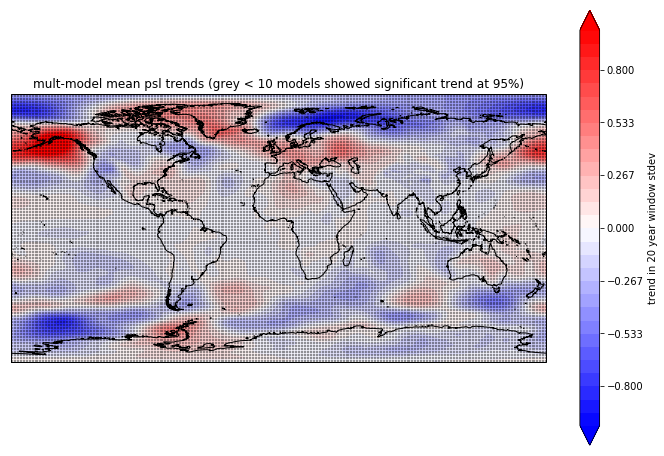

In [5]:

plt.close('all')
fig = plt.figure(figsize=[12, 8])
CS = iplt.contourf(cube3.collapsed('time',iris.analysis.MEAN),np.linspace(plot_min,plot_max,31),cmap='bwr',extend='both')

cbar = plt.colorbar(CS)
cbar.set_label('trend in '+str(window_size)+' year window stdev')

xv, yv = np.meshgrid( cube6.coord('longitude').points,cube6.coord('latitude').points)
xv[np.logical_not(np.isfinite(cube6_data))] = np.nan
yv[np.logical_not(np.isfinite(cube6_data))] = np.nan
plt.scatter(xv, yv,c='k',s=0.1,alpha=0.5)
# iplt.points(cube6,cmap='Greys',s=0.01)
plt.gca().coastlines('50m')
plt.title('mult-model mean psl trends (grey < '+str(no_models_sig)+' models showed significant trend at 95%)')
# plt.savefig('/home/ph290/Documents/figures/'+variable+'.png')
plt.show(block = False)




#### Plotting all models separately

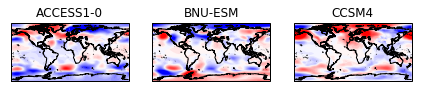

In [7]:
cube7_data = cube4_data.copy()
cube7_data[:] = np.nan
cube7_data[np.where(cube4_data > p_value_threshold)] = 1.0

plt.close('all')
fig = plt.figure(figsize=[30, 90])
for m,model in enumerate(models):
    plt.subplot(3,12, m+1)
    CS = iplt.contourf(cube3[m],np.linspace(plot_min,plot_max,31),cmap='bwr',extend='both')

#     cbar = plt.colorbar(CS)
    cbar.set_label('trend in '+str(window_size)+' year window stdev')

    xv, yv = np.meshgrid( cube3[m].coord('longitude').points,cube3[m].coord('latitude').points)
    xv[np.logical_not(np.isfinite(cube7_data[m,:,:]))] = np.nan
    yv[np.logical_not(np.isfinite(cube7_data[m,:,:]))] = np.nan
#     plt.scatter(xv, yv,c='k',s=0.1,alpha=0.5)
    # iplt.points(cube6,cmap='Greys',s=0.01)
    plt.gca().coastlines('50m')
    plt.title(models[m])
# plt.savefig('/home/ph290/Documents/figures/'+variable+'.png')

plt.show(block = False)



## Sea Surface Height

In [8]:

######### parameters ##########

variable = 'zos'
plot_min = -0.0001
plot_max = 0.0001
###############################


models = which_models(directory)




#### models being used

In [2]:
print models

['ACCESS1-0' 'BNU-ESM' 'CCSM4' 'CESM1-CAM5' 'CESM1-FASTCHEM' 'CESM1-WACCM'
 'CMCC-CESM' 'CMCC-CM' 'CMCC-CMS' 'CNRM-CM5' 'CanCM4' 'FIO-ESM'
 'GFDL-CM2p1' 'GFDL-CM3' 'GFDL-ESM2G' 'GFDL-ESM2M' 'GISS-E2-H'
 'GISS-E2-H-CC' 'GISS-E2-R' 'GISS-E2-R-CC' 'HadGEM2-CC' 'HadGEM2-ES'
 'IPSL-CM5A-LR' 'IPSL-CM5A-MR' 'IPSL-CM5B-LR' 'MIROC-ESM-CHEM' 'MIROC4h'
 'MIROC5' 'MPI-ESM-LR' 'MPI-ESM-MR' 'MPI-ESM-P' 'MRI-CGCM3' 'MRI-ESM1'
 'NorESM1-M' 'NorESM1-ME' 'bcc-csm1-1-m' 'inmcm4']


#### variance analysis
for each model
select Jan,feb,mar
mean values within each year
remove linear trend
calculate the standard deviation for each point and year within the window specified above (window centered on the year of interest)
loop through each lat and lon, calculateing the slope and the p-value on the correlation between the stdev timeseries at that point and a linearlly increasing array

In [3]:
#Set up variables to hold output

model = models[0]
file = directory+model+'_'+variable+'_historical_r1i1p1_regridded.nc'
#Load file
cube = iris.load_cube(file)
cube3 = cube[0:models.size].copy()
cube3_data = cube3.data.copy()
cube3_data[:] = np.nan
cube4 = cube[0:models.size].copy()
cube4_data = cube4.data.copy()
cube4_data[:] = np.nan
cube6 = cube[0].copy()
cube6.data[:] = np.nan



for m,model in enumerate(models):
    file = directory+model+'_'+variable+'_historical_r1i1p1_regridded.nc'
    #Load file
    cube = iris.load_cube(file)
    #extract Jan Feb Mar and average in each year
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    jan_feb_mar_loc = np.where((cube.coord('month').points == 'Jan') | (cube.coord('month').points == 'Feb') | (cube.coord('month').points == 'Mar'))
    cube = cube[jan_feb_mar_loc].aggregated_by('year', iris.analysis.MEAN)
    cube_data = cube.data
    #remove linear trend
    cube_data_detrended = scipy.signal.detrend(cube_data, axis=0)
    cube.data = cube_data_detrended
    cube2 = cube[int(window_size*0.5):int(window_size*-0.5)].copy()
    cube2_data = cube2.data.copy()
    cube2_data[:] = np.nan
    for i in range(cube2.shape[0]):
        cube2_data[i,:,:] = cube[i:window_size+i].collapsed('time',iris.analysis.STD_DEV).data
    for i in range(cube2.shape[1]):
        for j in range(cube2.shape[2]):
            slope, intercept, r_value, p_value, std_err = stats.linregress(range(cube2.shape[0]),cube2_data[:,i,j])
            cube3_data[m,i,j] = slope
            cube4_data[m,i,j] = p_value





/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacella', referenced by netCDF variable u'psl'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lat' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lon' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'time' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.

In [4]:

cube3.data = cube3_data
cube4.data = cube4_data
cube5_data = cube4_data.copy()
cube5_data[:] = 0.0
cube5_data[np.where(cube4_data > p_value_threshold)] = 1.0
cube5_data = np.sum(cube5_data,axis=0)
cube6_data = cube4_data[0,:,:].copy()
cube6_data[:] = np.nan
cube6_data[np.where(cube5_data < no_models_sig)] = 1.0
cube6.data = cube6_data



#### Plotting
Plot the multi-model mean slope, and mark in grey the areas where fewer than X models had significant trends (see figures for details)

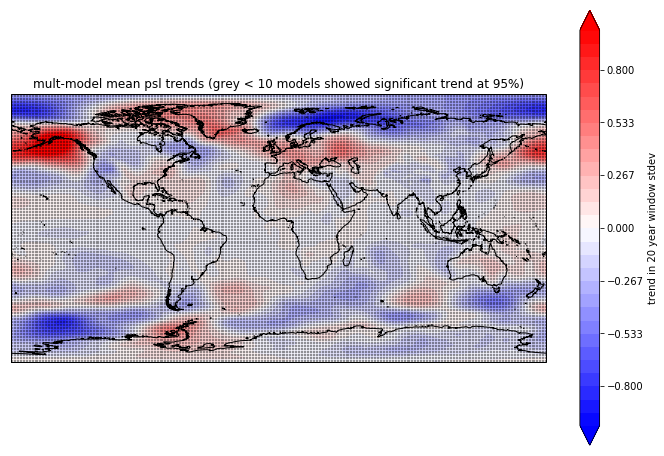

In [5]:

plt.close('all')
fig = plt.figure(figsize=[12, 8])
CS = iplt.contourf(cube3.collapsed('time',iris.analysis.MEAN),np.linspace(plot_min,plot_max,31),cmap='bwr',extend='both')

cbar = plt.colorbar(CS)
cbar.set_label('trend in '+str(window_size)+' year window stdev')

xv, yv = np.meshgrid( cube6.coord('longitude').points,cube6.coord('latitude').points)
xv[np.logical_not(np.isfinite(cube6_data))] = np.nan
yv[np.logical_not(np.isfinite(cube6_data))] = np.nan
plt.scatter(xv, yv,c='k',s=0.1,alpha=0.5)
# iplt.points(cube6,cmap='Greys',s=0.01)
plt.gca().coastlines('50m')
plt.title('mult-model mean psl trends (grey < '+str(no_models_sig)+' models showed significant trend at 95%)')
# plt.savefig('/home/ph290/Documents/figures/'+variable+'.png')
plt.show(block = False)




#### Plotting all models separately

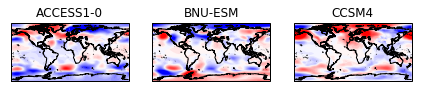

In [7]:
cube7_data = cube4_data.copy()
cube7_data[:] = np.nan
cube7_data[np.where(cube4_data > p_value_threshold)] = 1.0

plt.close('all')
fig = plt.figure(figsize=[30, 90])
for m,model in enumerate(models):
    plt.subplot(3,12, m+1)
    CS = iplt.contourf(cube3[m],np.linspace(plot_min,plot_max,31),cmap='bwr',extend='both')

#     cbar = plt.colorbar(CS)
    cbar.set_label('trend in '+str(window_size)+' year window stdev')

    xv, yv = np.meshgrid( cube3[m].coord('longitude').points,cube3[m].coord('latitude').points)
    xv[np.logical_not(np.isfinite(cube7_data[m,:,:]))] = np.nan
    yv[np.logical_not(np.isfinite(cube7_data[m,:,:]))] = np.nan
#     plt.scatter(xv, yv,c='k',s=0.1,alpha=0.5)
    # iplt.points(cube6,cmap='Greys',s=0.01)
    plt.gca().coastlines('50m')
    plt.title(models[m])
# plt.savefig('/home/ph290/Documents/figures/'+variable+'.png')

plt.show(block = False)

